# Task 2. Quantum circuit to produce the $\frac{1}{\sqrt{2}}( |01> + |10>)$ bell state

The task asks to build a circuit that produces the previous bell state by optimizing the parameters of the gates through gradient descent. I will use the PennyLane framework to compute the gradient of the circuit. The beginning point for the circuit is the following:

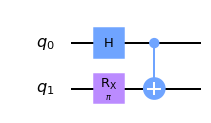

In [3]:
from qiskit import *
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane_cirq import ops as cirq_ops
import matplotlib.pyplot as plt

circ = QuantumCircuit(2)
circ.rx(np.pi,1)
circ.h(0)
circ.cx(0,1)
circ.draw('mpl')

This circuit would give us the required bell state when starting from both qubits set to |0>. We can express the previous circuit in terms of only Rx, Ry and C-Not gates in the following way:

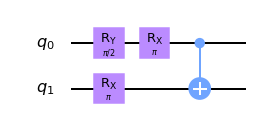

In [2]:
circ = QuantumCircuit(2)
circ.rx(np.pi,1)
circ.ry(np.pi/2,0)
circ.rx(np.pi,0)
circ.cx(0,1)
circ.draw('mpl')

The goal is to start with random angles in the gates and optimize the circuit to produce the $\frac{1}{\sqrt{2}}( |01> + |10>)$ state. We can measure the probability of the |01> and |10> from the previous circuit, but how could we measure the relative phase to make sure we produce the desired bell state? For this, I'll add to the previous circuit a bell state analyzer. A measurement in the Z-basis in this analyzer will output the values (+1,-1) for the qubits 0,1 ONLY if the input state is $\frac{1}{\sqrt{2}}( |01> + |10>)$. Thus, we can add terms related with this two measurement in the cost function in order to make sure the circuit produces the desired state. I will implement the bell state analyzer with the following circuit:

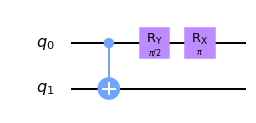

In [15]:
circ = QuantumCircuit(2)
circ.cx(0,1)
circ.ry(np.pi/2,0)
circ.rx(np.pi,0)
circ.draw('mpl')

To implement noise, I used the backend 'mixedsimulator' from CirqOps, making the bits flip with a probability p right before the measurement in both circuits. For the cost function, I used a simple absolute value function. 

---------------Number of shots: 1------------------

Optimized rotation angles (in units of pi): [ 1.0626574   0.0257791   0.41373942 -0.05183614 -0.36154228]
Probability of each state in the computational base: [0. 1. 0. 0.]
Result of the bell state analyzer: [ 1. -1.]


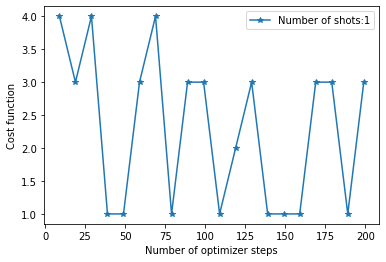

---------------Number of shots: 10------------------

Optimized rotation angles (in units of pi): [ 1.00454482  0.33900169  0.45788775 -0.52275989 -0.22143877]
Probability of each state in the computational base: [0.  0.4 0.4 0.2]
Result of the bell state analyzer: [ 1. -1.]


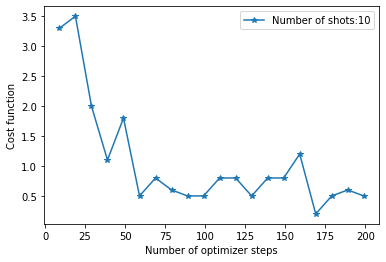

---------------Number of shots: 100------------------

Optimized rotation angles (in units of pi): [ 1.00652879 -0.51951803 -0.42280443  0.50831356 -0.01214404]
Probability of each state in the computational base: [0.01 0.38 0.55 0.06]
Result of the bell state analyzer: [ 0.86 -0.76]


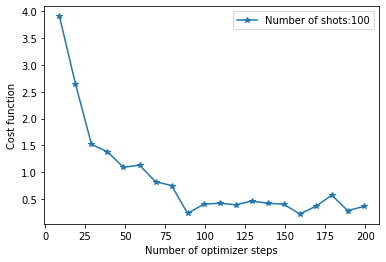

---------------Number of shots: 1000------------------

Optimized rotation angles (in units of pi): [ 1.00031819 -0.49300779 -0.29543397  0.49592295 -0.00206011]
Probability of each state in the computational base: [0.038 0.465 0.47  0.027]
Result of the bell state analyzer: [ 0.9   -0.812]


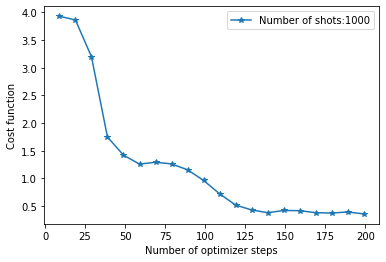

In [13]:
for shot in [1,10,100,1000]: # number of measurements
    
    dev1 = qml.device("cirq.mixedsimulator", wires=2, shots = shot, analytic=False) 
    
    
    #-------------------Building the circuits------------------
    
    p = 0.05 #5% probability of flipping a bit

    
    def ansatz(params): #
        qml.RX(params[0], wires=1) 
        qml.RY(params[1], wires=0) 
        qml.RX(params[2], wires=0) 
        cirq_ops.BitFlip(p, wires=0)
        cirq_ops.BitFlip(p, wires=1)
        qml.CNOT(wires =[0,1]) 
    

    @qml.qnode(dev1) 
    def circuit1(params):
        ansatz(params)
        return qml.probs(wires=[0,1])


    @qml.qnode(dev1) 
    def circuit2(params):  #bell state analyzer
        ansatz(params)
        qml.CNOT(wires =[0,1]) 
        qml.RY(params[3], wires=0) 
        qml.RX(params[4], wires=0) 
        cirq_ops.BitFlip(p, wires=0)
        cirq_ops.BitFlip(p, wires=1)
        return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))


    #-----------------Setting up the optimizer--------------
    
      
    def cost(params):  #Cost function 
        cost =  abs(circuit1(params)[0]) + abs(circuit1(params)[3]) + abs(0.5-circuit1(params)[1])+abs(0.5-circuit1(params)[2]) + abs(1-circuit2(params)[0]) + abs(1+circuit2(params)[1])
        return cost

    opt = qml.GradientDescentOptimizer(stepsize=0.1) #Gradient descent
    iteration=200
    iterationlist=[]
    params = np.random.rand(5)/10 #initialize parameters

    costs=[]

    for i in range(iteration):
        # update the circuit parameters
        params = opt.step(cost, params)
        if (i + 1) % 10 == 0:
            iterationlist.append(i)
            costs.append(cost(params))
            #print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
    print(f'---------------Number of shots: {shot}------------------')
    print()
    print("Optimized rotation angles (in units of pi): {}".format(params/np.pi))
    print('Probability of each state in the computational base:',circuit1(params))
    print('Result of the bell state analyzer:', circuit2(params))
    
    plt.plot(stepslist,costs,'-*', label = f'Number of shots:{shot}')
    plt.legend()
    plt.xlabel('Number of optimizer steps')
    plt.ylabel('Cost function')
    plt.show()
  

We can see that the more shots in the measurements we do, the lower the cost function gets, as we would expect. For 1 shot, results are too random in order to make the optimizer converge, and the produced state is |01>. This makes sense since we are doing only one measuremtent, so the produced state will not be a superposition but rather a pure state. For 1000 shots, the probabilities of getting |01> and |10> are 46.5% and 47.0% respectively, which is very close to the 50/50 we wanted to achieve. The result of the bell state analyzer shows a measurement +0.9,-0.812 meaning that in fact we are producing quantum states close to the $\frac{1}{\sqrt{2}}( |01> + |10>)$ state. 